In [1]:
import torch
import torchvision
from chatglm1 import *
from chatglm2 import *
import pandas as pd
import json
import time
import faiss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Dataloder import *
# from chains.local_doc_qa import LocalDocQA
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from langchain.docstore.base import AddableMixin, Docstore
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score,precision_recall_curve
# langchain.vectorstores.faiss
#加载全部数据库
# vector_data = read_json_file("/mnt/workspace/pangtianqi/medical_kb_chatbot/data/dataset1.json")
# vector_dataset = MyDataset(vector_data)
# vector_dataloader = torch.utils.data.DataLoader(vector_dataset, batch_size=1, shuffle=False)
#加载测试数据库
raw_data = read_json_file("/mnt/workspace/pangtianqi/medical_kb_chatbot/train/dataset2_RP_test.json")
testing_dataset = MyDataset(raw_data)
testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=False)

/home/pai/envs/kb_chat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-10-19 06:54:03,969] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# for batch_data in testing_dataloader:
#     query = batch_data[0][0]
#     # data = batch_data[1]
#     data,labels = batch_data[1:]
#     # labels = [torch.tensor(value) for value in labels]
#     formatted_data = [tuple(item[0]) for item in batch_data[1]]
#     print(formatted_data)

In [3]:
# print(len(raw_data))

In [4]:
#test_data = read_json_file("/mnt/workspace/pangtianqi/medical_kb_chatbot/train/test_finetune.json")

In [5]:
#加载模型chatglm1
model =  MyGLU(hidden_size = 768)
device = model.device
model.load_state_dict(torch.load("model/best_E5_chatglm1_L2_RP_v1.ph"))#
# model.load_state_dict(torch.load("/mnt/workspace/pangtianqi/medical_kb_chatbot/train/model/best_m3e_chatglm1_finetune_L2_v1.1.ph"))
# model.load_state_dict(torch.load("model/best_m3e_chatglm1_finetune_v2.ph"))
model = model.to(device)
# print(model)
# print(model)
encoder = model.embed_model
dim =768

Embedding size: 768


In [6]:
#加载模型chatglm2
# config = ChatGLMConfig()
# model = MyMLP(config)
# device = model.device
# model.load_state_dict(torch.load("model/best_E5_chatglm2_L2_RP_v1.ph"))

# model = model.to(device)
# print(model)
# # print(model)
# encoder = model.embed_model
# dim =768

In [7]:
# from sentence_transformers import SentenceTransformer
# encoder = SentenceTransformer('/mnt/workspace/pangtianqi/medical_kb_chatbot/moka-ai/m3e-base', device='cuda:0')

In [8]:
#labels_recall ->所有label存在一个列表
#labels ->按照问题划分的label列表
testing_text = []
labels_list = []
labels_list_recall = []
for batch_data in testing_dataloader:
    query = batch_data[0][0]
    # data = batch_data[1]
    data,label = batch_data[1:]
    # labels = [torch.tensor(value) for value in labels]
    # formatted_data = [tuple(item[0]) for item in batch_data[1]]
    # data = batch_data[1]
    # label = batch_data[2]
    for idx in data:
        for content in idx:
            testing_text.append(content)
    labels_list_recall.append(label)
    for i in label:
        labels_list.append(i)
    # print(labels_list)
labels_recall = [torch.cat(tensor).tolist() for tensor in labels_list_recall]
labels = [tensor.item() for tensor in labels_list]
print("testing_text",len(testing_text))
print("label_recall",len(labels_recall))

testing_text 23505
label_recall 282


In [9]:
#baseline: embedding vector_store
#index ->baseline的索引
content_list = []
for batch_data in testing_text:
    # data, label = batch_data[2:]
    content_vectors = encoder.encode(batch_data)
    content_list.append(content_vectors)

vectors = np.array(content_list,dtype=np.float32)
# augmented_vectors = np.flip(vectors, axis=1)
# vectors = np.ascontiguousarray(vectors)
# augmented_vectors = np.ascontiguousarray(augmented_vectors)
# combined_vectors = np.concatenate((vectors, augmented_vectors), axis=1,dtype=np.float32)
# print("原始数据形状:", vectors.shape)
# print("增强后的数据形状:", augmented_vectors.shape)
# print("拼接后的数据形状:", combined_vectors.shape)
# print("vectors",len(vectors))
# 选择faiss index
faiss.normalize_L2(vectors)
index = faiss.IndexFlatIP(dim)
# 数据插入
# 训练索引获取重构能力
index.train(vectors)
index.add(vectors)

In [10]:
#model: embedding vector_store
#index_ -> model的索引
content_list_ = []
for batch_data in testing_text:
    # data, label = batch_data[2:]
    content_vectors_ = model(batch_data)
    content_vectors_ = content_vectors_.cpu()
    content_vectors_ = content_vectors_.detach().numpy()
    content_list_.append(content_vectors_)

vectors_ = np.array(content_list_,dtype=np.float32)
print("vectors_",vectors_.shape)

# 选择faiss index
faiss.normalize_L2(vectors_)


index_ = faiss.IndexFlatIP(dim)

# 数据插入
# 训练索引获取重构能力
index_.train(vectors_)
index_.add(vectors_)

vectors_ (23505, 768)


In [11]:
#baseline -> 计算准确率，召回率、精度
k = [2,4,6,8,10,20,30]
for top_k in k:
    print("top_k",top_k)
    count= 0
    precision_all, recall_all, accuracy_all = 0, 0, 0
    start_time = time.time()
    label_pair = []
    D_pair = []
    score_pair = []
    text_list = []
    query_list = []
    len_query = len(testing_dataloader)
    hit_count = 0
    for batch_data in testing_dataloader:
        count_1 = 0
        tp, fp, fn, tn = 0, 0, 0, 0
        query = batch_data[0][0]
        # print("query",query)
        # query_list.append(query)
        # data = batch_data[1]
        data,label = batch_data[1:]
        # print(len(data))
        query_feat = np.array([encoder.encode(query)]) # 得到baseline query embed
        faiss.normalize_L2(query_feat)
        # query_feat = query_feat.squeeze(0)
        # print(query_feat.shape)
        # print("hello")
        D, I= index.search(query_feat, top_k) #提取出ours的topk
        #print('scores_, indices_',D_, I_[0])
        
        D_pair.append(D)
        for value in label:
            if value == 1:
                count_1 += 1 #这个q对应的回答中所有label为1的个数
        #print("count_1",count_1)
        # for text in I_[0]:
            # text_list.append(testing_text[text])
            #print("content",testing_text[text])
        for i in I[0]:
            #print("labels[i]",labels[i])
            label_pair.append(labels[i])
        # lst = [] # 模型召回的
        
        # count_0 = len(label[0])
        for i in I[0]:
            if labels[i] == 1:
                tp = tp+1
            # elif labels[i] == 0: # 若labels=1的在模型中的label也等于１
            #     break
        #print("tp",tp)
        #print(len(label))
        if top_k < len(label):
            fp = top_k-tp
        else:
            fp = len(label)-tp
        #print("fp",fp)
        fn = count_1-tp
        #print("fn",fn)
        count_0 = len(labels)-count_1
        tn = count_0-fp
        
        if count_1!=0 : #排除label全为1或全为0的情况
            count+=1
            precision = float(tp/(tp+fp))
            if tp >= count_1:
                recall = 1.0
            else:
                recall = float(tp/(tp+fn))
            accuracy = float((tp+tn)/(tp+fp+tn+fn))

            precision_all += precision
            recall_all += recall
            accuracy_all += accuracy
        if tp!= 0:
            hit_count +=1
        # if count_1 == 0:
        #     len_query -= 1
    print("hit_count",hit_count)
    print("len_query",len_query)
    for item in D_pair:
        for score in item:
            score_pair.extend(score)
    # print("score_pair",len(score_pair_))
    # print("label_pair",len(label_pair_))
    print(f"top_{top_k},recall_ave_m3e: {float(recall_all/count)}")
    print(f"top_{top_k},precision_ave_m3e: {float(precision_all/count)}")
    mAP = average_precision_score(label_pair, score_pair, average='macro')
    print(f"top_{top_k},mAP_m3e:", mAP)
    #print(f"accuracy_ave_m3e: {float(accuracy_all/count)}")
    print(f"top_{top_k},hit_rate_ave_m3e:{float(hit_count/len_query)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    # print("text_list",text_list)
    print(f"Time spent: {elapsed_time:.5f} seconds")

top_k 2
hit_count 218
len_query 282
top_2,recall_ave_m3e: 0.052164534853564266
top_2,precision_ave_m3e: 0.5957446808510638
top_2,mAP_m3e: 0.6432178367286865
top_2,hit_rate_ave_m3e:0.7730496453900709
Time spent: 22.44865 seconds
top_k 4
hit_count 249
len_query 282
top_4,recall_ave_m3e: 0.10636640777275476
top_4,precision_ave_m3e: 0.5851063829787234
top_4,mAP_m3e: 0.624196155933284
top_4,hit_rate_ave_m3e:0.8829787234042553
Time spent: 22.51028 seconds
top_k 6
hit_count 256
len_query 282
top_6,recall_ave_m3e: 0.1488666733637538
top_6,precision_ave_m3e: 0.5756501182033095
top_6,mAP_m3e: 0.6128928916372325
top_6,hit_rate_ave_m3e:0.9078014184397163
Time spent: 22.50527 seconds
top_k 8
hit_count 268
len_query 282
top_8,recall_ave_m3e: 0.1891304533108691
top_8,precision_ave_m3e: 0.5664893617021277
top_8,mAP_m3e: 0.6044061404473416
top_8,hit_rate_ave_m3e:0.950354609929078
Time spent: 22.50502 seconds
top_k 10
hit_count 269
len_query 282
top_10,recall_ave_m3e: 0.22901238994888956
top_10,precisio

precision 0.2943275682905304
recall 0.28340604588520013
thresholds 0.44146433039337185
mAP_glm1: 0.567839407668933


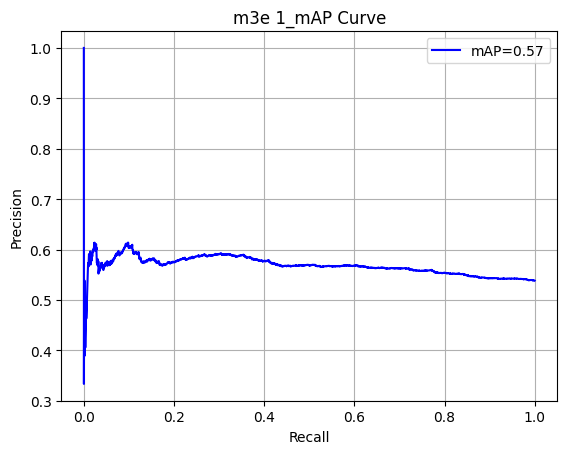

In [12]:
#baseline ->计算mAP

import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score,precision_recall_curve
length = len(label_pair)
# 计算不同阈值下的精确率和召回率
precision, recall, thresholds = precision_recall_curve(label_pair, score_pair)
print("precision",sum(precision)/length)
print("recall",sum(recall)/length)
print("thresholds",sum(thresholds)/length)
# 计算每个阈值下的平均精度均值
# average_precision = average_precision_score(true_labels, predicted_probs)
mAP = average_precision_score(label_pair, score_pair, average='macro')
print("mAP_glm1:", mAP)

# 绘制曲线图
plt.plot(recall, precision, color='b', label=f'mAP={mAP:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('m3e 1_mAP Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [13]:
top_k = 2
# text_list = []
result_m3e = {}  # 创建空字典    
for i,batch_data in enumerate(testing_dataloader):
     query = batch_data[0][0]
     query_feat = np.array([encoder.encode(query)])
     # query_feat_ = model(query) # 得到model query embed
     # query_feat_ = query_feat_.cpu()
     # query_feat_ = np.array([query_feat_.detach()])
     faiss.normalize_L2(query_feat)
     D, I= index.search(query_feat, top_k) 
     text_list = []
     for text in I[0]:
          text_list.append(testing_text[text])
     # print(text_list)
          # content = testing_text[text]
     result_m3e[i] = {
          "query": query,
          "content": text_list,
          "score": D
     }  
     result_m3e[i]['score'] = result_m3e[i]['score'].tolist()
# print(result_m3e)

In [14]:
import json
# result[0]['score'] = result[0]['score'].tolist()
# print(result)
# 将字典转换为 JSON 字符串
json_data_ = json.dumps(result_m3e,ensure_ascii=False)

# 将 JSON 字符串保存到本地文件
file_path = "result_m3e.json"
with open(file_path, "w", encoding="utf-8") as file:
    file.write(json_data_)

In [15]:
#model -> 计算准确率，召回率、精度
k = [2,4,6,8,10,20,30]
for top_k in k:
    print("top_k",top_k)
    count= 0
    precision_all, recall_all, accuracy_all = 0, 0, 0
    start_time = time.time()
    label_pair_ = []
    D_pair_ = []
    score_pair_ = []
    text_list = []
    query_list = []
    len_query = len(testing_dataloader)
    hit_count = 0
    for batch_data in testing_dataloader:
        count_1 = 0
        tp, fp, fn, tn = 0, 0, 0, 0
        query = batch_data[0][0]
        # print("query",query)
        # query_list.append(query)
        data,label = batch_data[1:]
        # print(len(data))
        # query_feat = np.array([encoder.encode(query)]) # 得到baseline query embed
        query_feat_ = model(query) # 得到model query embed
        query_feat_ = query_feat_.cpu()
        query_feat_ = np.array([query_feat_.detach()])
        faiss.normalize_L2(query_feat_)
        #query_feat_ = query_feat_.squeeze(0)
        D_, I_ = index_.search(query_feat_, top_k) #提取出ours的topk
        #print('scores_, indices_',D_, I_[0])
        D_pair_.append(D_)
        for value in label:
            if value == 1:
                count_1 += 1 #这个q对应output_tensor = input_tensor.squeeze(0)的回答中所有label为1的个数
        #print("count_1",count_1)
        for i in I_[0]:
            #print("labels[i]",labels[i])
            label_pair_.append(labels[i])
        # count_0 = len(label[0])
        for i in I_[0]:
            if labels[i] == 1:
                tp = tp+1

        if top_k < len(label):
            fp = top_k-tp
        else:
            fp = len(label)-tp
        #print("fp",fp)
        fn = count_1-tp
        #print("fn",fn)
        count_0 = len(labels)-count_1
        tn = count_0-fp
        if count_1!=0 : #排除label全为1或全为0的情况
            count+=1
            precision = float(tp/(tp+fp))
            accuracy = float((tp+tn)/(tp+fp+tn+fn))
            if tp >= count_1:
                recall = 1.0
            else:
                recall = float(tp/(tp+fn))
            # print("recall",recall)
            precision_all += precision
            recall_all += recall
            accuracy_all += accuracy
        if tp!= 0:
            hit_count +=1
        # if count_1 == 0:
        #     len_query -= 1
    print("hit_count",hit_count)
    print("len_query",len_query)
    for item in D_pair_:
        for score in item:
            score_pair_.extend(score)
    # print("score_pair",len(score_pair_))
    # print("label_pair",len(label_pair_))
    print(f"top_{top_k},recall_ave_model: {float(recall_all/count)}")
    print(f"top_{top_k},precision_ave_model: {float(precision_all/count)}")
    mAP = average_precision_score(label_pair_, score_pair_, average='macro')
    print(f"top_{top_k},mAP_model:", mAP)
    #print(f"accuracy_ave_m3e: {float(accuracy_all/count)}")
    print(f"top_{top_k},hit_rate_ave_model:{float(hit_count/len_query)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    # print("text_list",text_list)
    print(f"Time spent: {elapsed_time:.5f} seconds")

top_k 2
hit_count 261
len_query 282
top_2,recall_ave_model: 0.08027311099419038
top_2,precision_ave_model: 0.8599290780141844
top_2,mAP_model: 0.9251669440493758
top_2,hit_rate_ave_model:0.925531914893617
Time spent: 22.35856 seconds
top_k 4
hit_count 278
len_query 282
top_4,recall_ave_model: 0.153331646926158
top_4,precision_ave_model: 0.8661347517730497
top_4,mAP_model: 0.9413237650125266
top_4,hit_rate_ave_model:0.9858156028368794
Time spent: 22.50326 seconds
top_k 6
hit_count 282
len_query 282
top_6,recall_ave_model: 0.21862814957363114
top_6,precision_ave_model: 0.8392434988179671
top_6,mAP_model: 0.890302754923437
top_6,hit_rate_ave_model:1.0
Time spent: 22.52262 seconds
top_k 8
hit_count 282
len_query 282
top_8,recall_ave_model: 0.2791703342115318
top_8,precision_ave_model: 0.8377659574468085
top_8,mAP_model: 0.8872341741692393
top_8,hit_rate_ave_model:1.0
Time spent: 22.57989 seconds
top_k 10
hit_count 282
len_query 282
top_10,recall_ave_model: 0.3339878559080466
top_10,precisi

In [16]:
import numpy as np

def compute_kl_divergence(p, q):
    kl_divergence = np.sum(p * np.log(p / q))
    return kl_divergence

# 示例：计算两个离散概率分布的KL散度
p = np.array(score_pair)
q = np.array(score_pair_)
print("p",p)
print("q",q)
kl_divergence = compute_kl_divergence(p, q)
print("KL散度:", kl_divergence)

p [0.9158952  0.91430676 0.90869284 ... 0.8506801  0.8506488  0.8506488 ]
q [0.97398615 0.9710238  0.9701721  ... 0.9661951  0.9656285  0.9656216 ]
KL散度: -653.86975


precision 0.40857028269421036
recall 0.2607524961415069
thresholds 0.48268876575972736
mAP_glm1: 0.7982750808619401


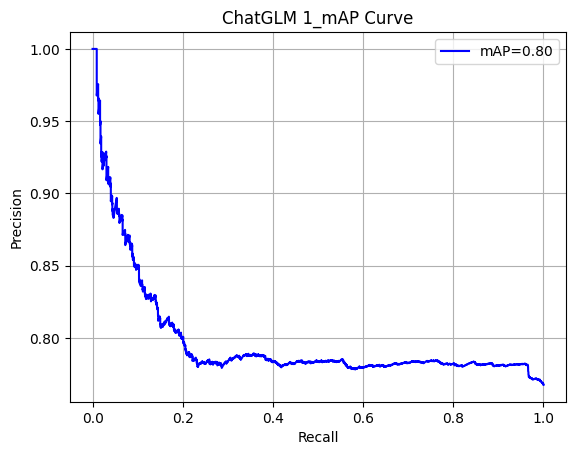

In [17]:
#model ->计算mAP
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score,precision_recall_curve
length = len(label_pair_)
# 计算不同阈值下的精确率和召回率
precision, recall, thresholds = precision_recall_curve(label_pair_, score_pair_)
print("precision",sum(precision)/length)
print("recall",sum(recall)/length)
print("thresholds",sum(thresholds)/length)
# 计算每个阈值下的平均精度均值
# average_precision = average_precision_score(true_labels, predicted_probs)
mAP = average_precision_score(label_pair_, score_pair_, average='macro')
print("mAP_glm1:", mAP)

# 绘制曲线图
plt.plot(recall, precision, color='b', label=f'mAP={mAP:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ChatGLM 1_mAP Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [18]:
#存储检索结果
top_k = 6
# text_list = []
result = {}  # 创建空字典    
for i,batch_data in enumerate(testing_dataloader):
     query = batch_data[0][0]
     query_feat_ = model(query) # 得到model query embed
     query_feat_ = query_feat_.cpu()
     query_feat_ = np.array([query_feat_.detach()])
     faiss.normalize_L2(query_feat_)
     # query_feat_ = query_feat_.squeeze(0)
     D_, I_ = index_.search(query_feat_, top_k) 
     text_list = []
     for text in I_[0]:
          text_list.append(testing_text[text])
     # print(text_list)
          # content = testing_text[text]
     result[i] = {
          "query": query,
          "content": text_list,
          "score": D_
     }  
     result[i]['score'] = result[i]['score'].tolist()
# print(result)
     

In [19]:
import json
# 将字典转换为 JSON 字符串
json_data = json.dumps(result,ensure_ascii=False)
# 将 JSON 字符串保存到本地文件
file_path = "result.json"
with open(file_path, "w", encoding="utf-8") as file:
    file.write(json_data)

In [20]:
#单个查询

query = "消化不良能吃乳酶生片吗？"
#乳酶生片
top_k = 10
start_time = time.time()
query_feat = np.array([encoder.encode(query)])   
faiss.normalize_L2(query_feat)
D, I = index.search(query_feat, top_k) 
text_list = []
for text in I[0]:
    # text_list.append(testing_text[text])
    print(testing_text[text])
#print(D)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time spent: {elapsed_time:.2f} seconds")

Materials and methods -Experimental animals:Six-week-old female C57BL/6 mice were purchased from VITAL RIVER (Beijing, China). Mice were housed, handled, and immunized at the animal biosafety facilities and all procedures were approved by the institutional animal experimental committee of Yangzhou University. All *M. tuberculosis* H37Rv challenge experiments were performed in the Animal Biosafety Level 3 (ABSL-3) facility of Wuhan
Disclaimer-The views expressed in this article are those of the author(s) and do not necessarily reflect the official policy of the Department of Defense, Department of the Army, U.S. Army Medical Department or the U.S.
Disclaimer-The views expressed in this article are those of the author(s) and do not necessarily reflect the official policy of the Department of Defense, Department of the Army, U.S. Army Medical Department or the U.S.
Disclaimer-The views expressed in this article are those of the author(s) and do not necessarily reflect the official policy 

In [21]:
#单个查询蒲地蓝消炎片|蒲地蓝消炎口服液
# query = "急性肠胃炎吃什么药？"
# top_k = 2
start_time = time.time()
query_ = model(query) # 得到model query embed
query_= query_.cpu()
query_ = np.array([query_.detach()])
faiss.normalize_L2(query_)
D_, I_ = index_.search(query_, top_k) 
text_list = []
for text in I_[0]:
    # text_list.append(testing_text[text])
    print(testing_text[text])
# print(D_)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time spent: {elapsed_time:.2f} seconds")

Discussion -Stepwise posterior shift of the G1/S transition window :Recently, a Doppler effect has been reported to be involved in zebrafish segmentation [@pcbi.1003957-Soroldoni1]. Time-lapse observations of the transcriptional activity of *her1*, a component of the segmentation clock, during embryonic development revealed that its oscillation in the posterior portion is slower than that in the anterior part. Since the anterior oscillation is directly linked to
Discussion -Stepwise posterior shift of the G1/S transition window :Recently, a Doppler effect has been reported to be involved in zebrafish segmentation [@pcbi.1003957-Soroldoni1]. Time-lapse observations of the transcriptional activity of *her1*, a component of the segmentation clock, during embryonic development revealed that its oscillation in the posterior portion is slower than that in the anterior part. Since the anterior oscillation is directly linked to
Discussion -Stepwise posterior shift of the G1/S transition window